# Part III: Model Selection and Prediction
## MS: Examining XGBoost Performance with Preprocessing in Pipeline

In [2]:
import numpy as np
import pandas as pd
train_df = pd.read_csv("datasets/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8') 
test_df = pd.read_csv("datasets/testData.tsv", header=0, \
                    delimiter="\t", quoting=3,encoding='utf-8')
merged_desc_12g=pd.read_csv('datasets/merged_desc_12g.csv')

In [3]:
##### create X and Y for xgboost pipeline, scaling and selecting percentile for each fold
X=merged_desc_12g.iloc[:len(train_df),1:]
Y=train_df['sentiment']
unk_features=merged_desc_12g.iloc[len(train_df):,1:]
unk_ids=merged_desc_12g.iloc[len(train_df):,0]

In [8]:
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import FeatureUnion, Pipeline
import xgboost as xg

# create feature union
features = []
#features.append(('box_cox_transform',boxcox1p(lmbda=0.15)))
features.append(('min_max_scale',MinMaxScaler()))
features.append(('select_best',SelectPercentile(chi2, 25)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', xg.XGBClassifier(objective = 'binary:logistic',min_child_weight = 1,seed=1)))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
#kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(model, X, Y, cv=5, scoring='accuracy',n_jobs=-1,verbose=True)

print(results.mean())

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.6min finished


0.80296


#### Observation
It seems like using preprocessing through each kfold returns a score of 80%. The next steps will examine if doing preprocessing before fitting will return a higher score.

## MS: Comparing Performance of Different Models
### Preprocessing: Scaling and Selecting Top 25% Most Important Features

In [4]:
#scale
from sklearn.preprocessing import MinMaxScaler #Standardisation
merged_desc_12g_prescaled=merged_desc_12g.copy()
features_to_scale=merged_desc_12g.columns[1:].tolist()

for f in features_to_scale:
    merged_desc_12g[f]=MinMaxScaler().fit_transform(merged_desc_12g[f].as_matrix().reshape(-1,1)).flatten()

/Users/Sean/anaconda3/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# refresh X&Y
from sklearn.feature_selection import SelectPercentile, chi2
X=merged_desc_12g.iloc[:len(train_df),1:]
Y=train_df['sentiment']
unk_features=merged_desc_12g.iloc[len(train_df):,1:]
unk_ids=merged_desc_12g.iloc[len(train_df):,0]

# select top 25% of features
feats_25 = SelectPercentile(chi2, 25).fit(X, Y)
X = feats_25.transform(X)
unk_features = feats_25.transform(unk_features)

In [6]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
df_to_split=pd.concat([train_df['sentiment'],merged_desc_12g.iloc[:len(train_df),1:]],axis=1)

train,test=train_test_split(df_to_split,test_size=0.3,random_state=0,stratify=df_to_split.iloc[:,0],shuffle=True)

train_X=train.iloc[:,1:]
train_Y=train.iloc[:,0]
test_X=test.iloc[:,1:]
test_Y=test.iloc[:,0]

X=merged_desc_12g.iloc[:len(train_df),1:]
Y=train_df['sentiment']

unk_features=merged_desc_12g.iloc[len(train_df):,1:]
unk_ids=merged_desc_12g.iloc[len(train_df):,0]

In [7]:
# select percentile for test train split
feats_25 = SelectPercentile(chi2, 25).fit(X, Y)
X = feats_25.transform(X)
unk_features=feats_25.transform(unk_features)
train_X=feats_25.transform(train_X)
test_X=feats_25.transform(test_X)

## RBF SVM Performance

('Accuracy for rbf SVM is ', 0.88080000000000003)


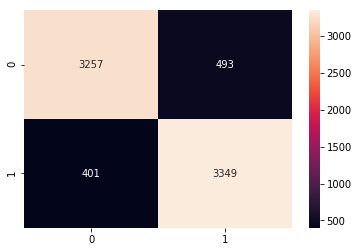

In [44]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction1),annot=True,fmt='2.0f')

## Linear SVM Performance

('Accuracy for linear SVM is ', 0.87946666666666662)


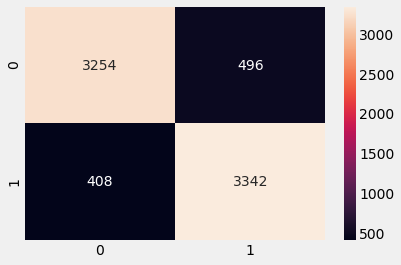

In [48]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is ',metrics.accuracy_score(prediction2,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction2),annot=True,fmt='2.0f')

## Logistic Regression Performance

('Accuracy for Logistic Regression is ', 0.88066666666666671)


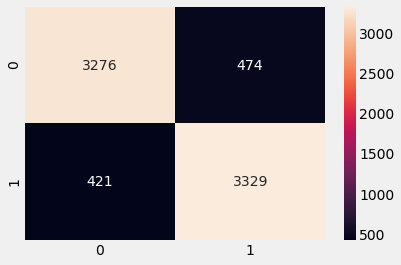

In [49]:
model=LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('Accuracy for Logistic Regression is ',metrics.accuracy_score(prediction3,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction3),annot=True,fmt='2.0f')

## Decision Tree Performance

('Accuracy for rbf SVM is ', 0.71906666666666663)


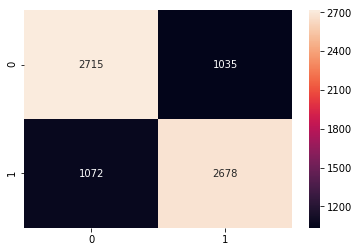

In [49]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction4,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction4),annot=True,fmt='2.0f')

## Random Forest Performance

('The accuracy of the Random Forests is', 0.84706666666666663)


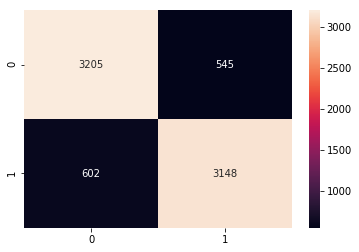

In [50]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction5,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction5),annot=True,fmt='2.0f')

## Adaboost Performance

('The accuracy of the AdabBoost is', 0.80066666666666664)


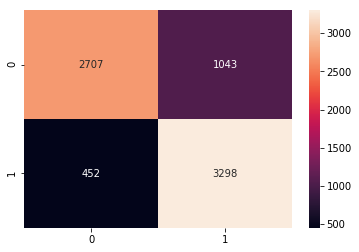

In [53]:
from sklearn.ensemble import AdaBoostClassifier
model=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the AdabBoost is',metrics.accuracy_score(prediction6,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction6),annot=True,fmt='2.0f')

## GradientBoosting Performance

('The accuracy of the Random Forests is', 0.85866666666666669)


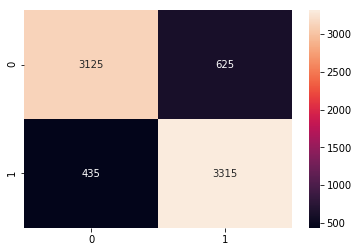

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the GradientBoostingClassifier is',metrics.accuracy_score(prediction7,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction7),annot=True,fmt='2.0f')

## XGBoost Performance

('The accuracy of the XgBoost is', 0.86773333333333336)


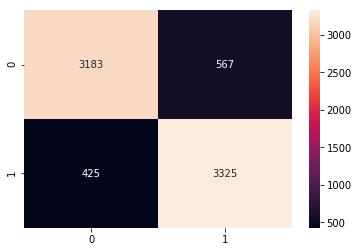

In [55]:
model=xg.XGBClassifier(n_estimators=1000,learning_rate=0.1)
model.fit(train_X,train_Y)
prediction8=model.predict(test_X)
print('The accuracy of the XgBoost is',metrics.accuracy_score(prediction8,test_Y))
sns.heatmap(confusion_matrix(test_Y,prediction8),annot=True,fmt='2.0f')

#### Observation
The logistic regression model has the best performance for overall run time. Tuning some hyperparameters may be able to further increase the model's efficacy. 

## MS: Hyperparameter Tuning for Logistic Regression and Bagged Predictions
### Tuning Logistic Regression Model

In [11]:
#Logistic Regression has the highest accuracy
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
penalty=['l1','l2']
hyper={'C':C,'penalty':penalty}
gd=GridSearchCV(estimator=LogisticRegression(random_state=0),param_grid=hyper,verbose=True,cv=5,scoring='roc_auc')
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.9min finished


0.950276576
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Bagged Predictions
With the hyperparameters optimized, 15 series of predictions will be made using the tuned logistic regression model by predicting on 15 random states.

In [29]:
sample_sub=pd.read_csv('datasets/sampleSubmission.csv')
#bag of 15 models
clf=LogisticRegression(C=0.9,penalty='l2')
rounds = 15
preds_mat = np.zeros((len(unk_ids.index), rounds))
for i in range(rounds):
    clf.set_params(random_state = i + 1)
    clf.fit(X, Y)
    preds_tmp = clf.predict_proba(unk_features)[:, 1]
    preds_mat[:, i] = preds_tmp
bagged_preds = preds_mat.mean(axis = 1)
log_reg_bag=pd.DataFrame({'id':sample_sub['id'],'sentiment':bagged_preds}).reset_index(drop=True)
log_reg_bag.to_csv('submissions/log_reg_bag.csv', index = False)

### Results
When uploaded to kaggle, the submission scores a 94.793%: a score within the top 30% of submissions. I'm happy with this score, but if I were to improve on this project I might choose to increase the number of max features outputted by the tfidf vectorizer. This would increase the runtime of training and optimizing model algorithms, however, which would not be favorable given the limitations of the computer I created this notebook on.

### Feature Importance
The tfidf vectorizer took n-grams of size 1 and 2. Using the "feature importance" property of ensembled models will show which n-grams or calculated descriptive statistics were the most influential on model performance.

/Users/Sean/anaconda3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


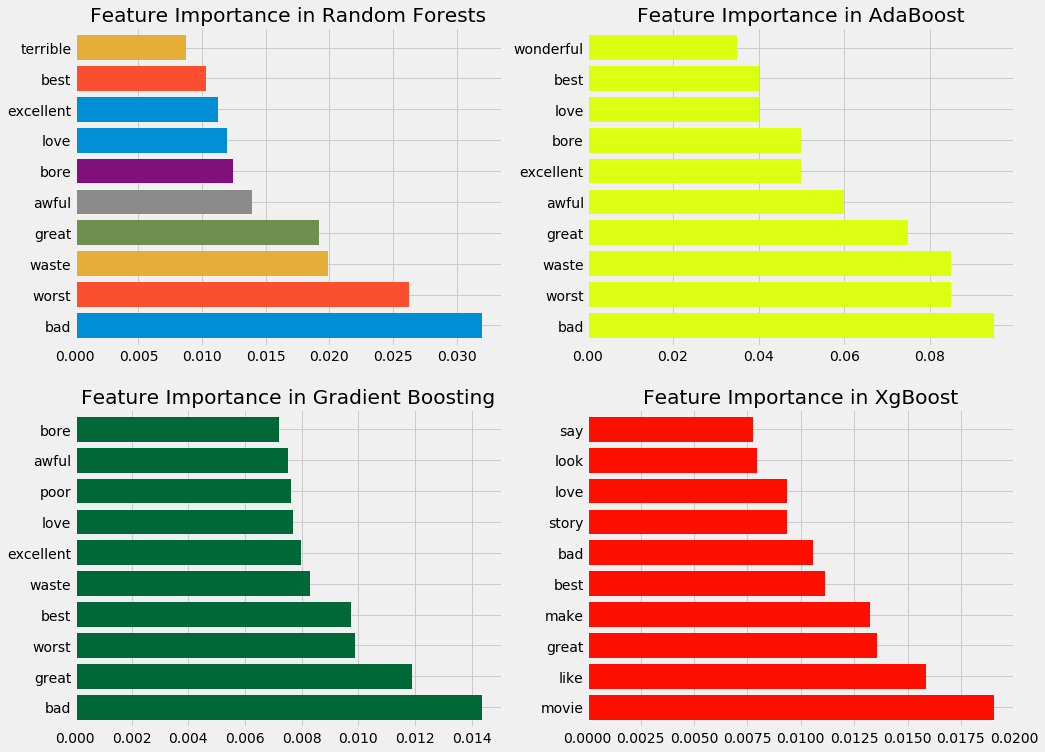

In [47]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xg
import seaborn as sns
% matplotlib inline
plt.style.use('fivethirtyeight')

columns = np.asarray(merged_desc_12g.iloc[:len(train_df),1:].columns.values)
support = np.asarray(feats_25.get_support())
columns_with_support = columns[support]
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,columns_with_support).sort_values(ascending=False).head(10).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,columns_with_support).sort_values(ascending=False).head(10).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,columns_with_support).sort_values(ascending=False).head(10).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,columns_with_support).sort_values(ascending=False).head(10).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()